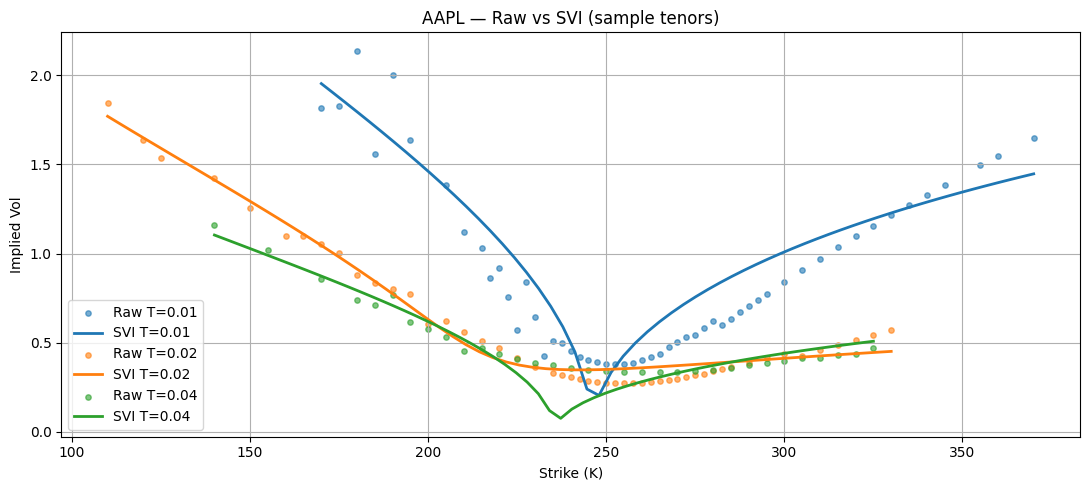

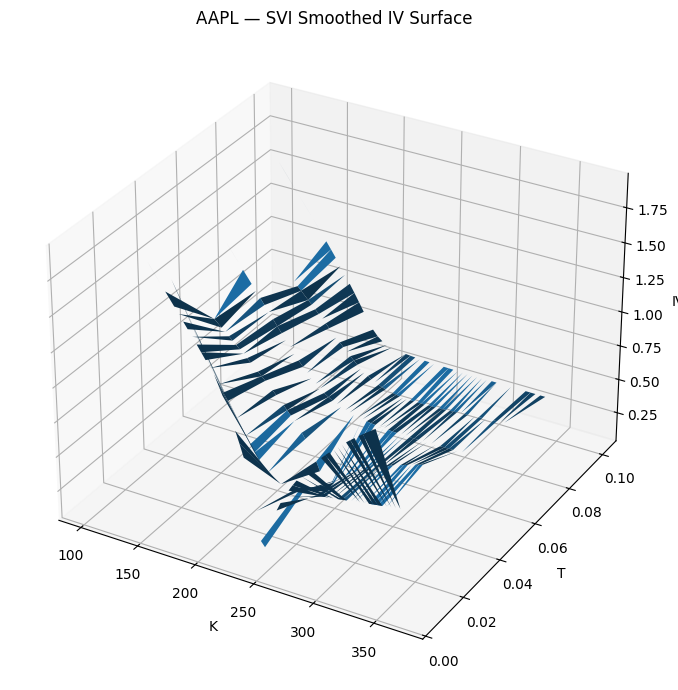

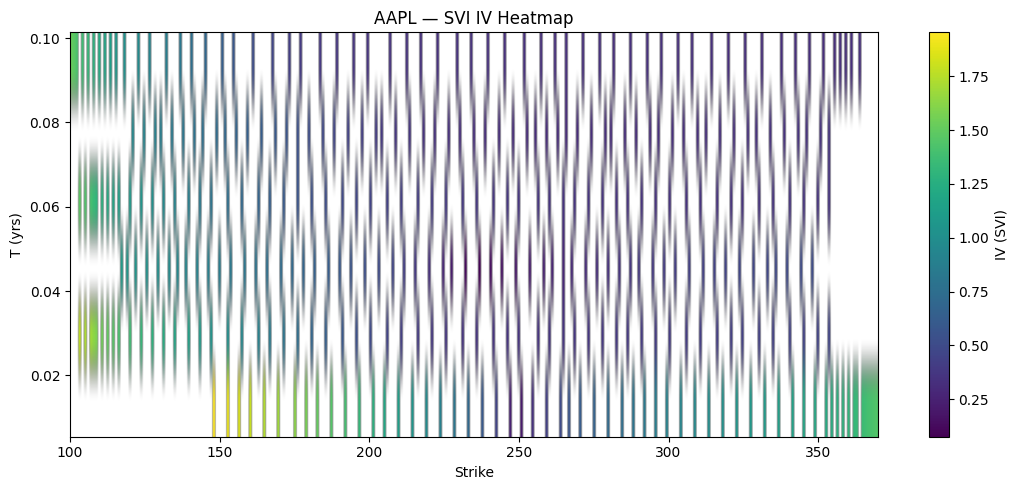

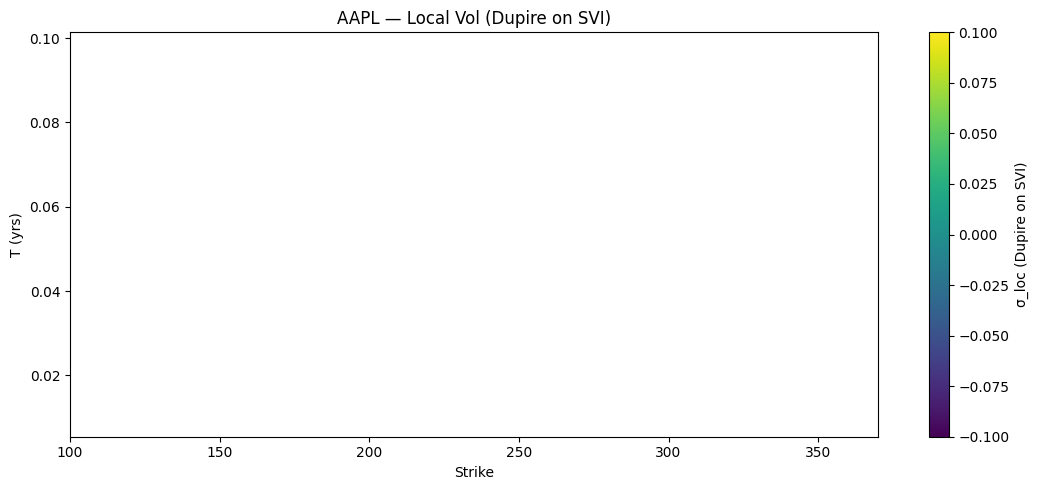

Saved CSVs: AAPL_iv_raw_points.csv AAPL_iv_svi_points.csv


In [1]:
# Step 13 — Regularized IV Surface via SVI slice fitting + Dupire on smoothed surface
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from datetime import datetime, timezone
from scipy.optimize import minimize
from scipy.stats import norm

# ---------- Black–Scholes & IV helpers ----------
def bs_call_price(S, K, T, r, q, sigma):
    if T <= 0:  return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0.0)
    if sigma <= 0: return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0.0)
    d1 = (np.log((S*np.exp(-q*T))/(K*np.exp(-r*T))) + 0.5*sigma*sigma*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_binary(C_mkt, S, K, T, r=0.02, q=0.0, tol=1e-6, low=1e-6, high=5.0, max_iter=100):
    intrinsic = max(0.0, S*np.exp(-q*T) - K*np.exp(-r*T))
    if C_mkt < intrinsic - 1e-10: return np.nan
    if abs(C_mkt - intrinsic) < 1e-12: return 0.0
    lo, hi = low, high
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        price = bs_call_price(S,K,T,r,q,mid)
        if abs(price - C_mkt) < tol: return mid
        if price > C_mkt: hi = mid
        else: lo = mid
    return mid

# ---------- Pull raw IV points ----------
def pull_iv_points(ticker="AAPL", max_expiries=6, r=0.02, q=0.0):
    tk=yf.Ticker(ticker)
    spot = tk.history(period="1d")["Close"]
    if spot.empty: raise SystemExit("No spot data.")
    S=float(spot.iloc[-1])

    exps = tk.options
    if not exps: raise SystemExit("No options listed.")
    exps = exps[:max_expiries]
    now = datetime.now(timezone.utc)

    rows=[]
    for exp in exps:
        ch = tk.option_chain(exp)
        calls = ch.calls.copy()
        if calls.empty: continue
        calls["mid"]=(calls["bid"].fillna(0)+calls["ask"].fillna(0))/2.0
        calls = calls.dropna(subset=["mid"])
        if calls.empty: continue
        T = max((pd.to_datetime(exp).tz_localize("UTC")-now).days/365.0,1e-6)
        # IV per strike from call mid
        ivs=[]
        for _,r_ in calls.iterrows():
            K=float(r_["strike"]); Cmid=float(r_["mid"])
            iv = implied_vol_binary(Cmid,S,K,T,r=r,q=q)
            if np.isfinite(iv) and 0<iv<5.0:
                ivs.append((T,K,iv))
        if ivs:
            df=pd.DataFrame(ivs,columns=["T","K","iv"])
            rows.append(df)
    if not rows: raise SystemExit("No usable IV quotes.")
    iv = pd.concat(rows,ignore_index=True).sort_values(["T","K"]).reset_index(drop=True)
    return S, iv

# ---------- SVI slice model ----------
def svi_total_variance(k, a,b,rho,m,sig):
    # w(k) = a + b ( rho*(k-m) + sqrt((k-m)^2 + sig^2) ), sig>0, b>0, |rho|<1
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sig**2))

def fit_svi_slice(k, w, lam_curv=1e-4):
    # least-squares with light curvature penalty on second derivative of w_model
    # Bounds promote basic SVI sanity: a>=0, b>0, |rho|<1, sig>0, m free
    k = np.asarray(k); w = np.asarray(w)
    # crude inits
    a0 = max(1e-6, np.percentile(w,5))
    b0 = 0.5
    rho0 = -0.3
    m0 = np.median(k)
    sig0 = 0.2
    x0 = np.array([a0,b0,rho0,m0,sig0])
    bounds = [(0.0, 10.0), (1e-6, 10.0), (-0.999, 0.999), (-3.0, 3.0), (1e-6, 3.0)]

    def obj(x):
        a,b,rho,m,sig = x
        wm = svi_total_variance(k,a,b,rho,m,sig)
        # curvature penalty via discrete second differences
        # (encourages convexity in k)
        if len(k) >= 3:
            idx = np.argsort(k)
            kd = k[idx]; wd = wm[idx]
            d2 = np.diff(wd,2)
            pen = lam_curv * np.sum(np.maximum(-d2, 0.0)**2)
        else:
            pen = 0.0
        return np.mean((wm - w)**2) + pen

    res = minimize(obj, x0, bounds=bounds, method="L-BFGS-B")
    return res.x, res.success

# ---------- Build smoothed SVI surface ----------
def build_svi_surface(ticker="AAPL", max_expiries=6, r=0.02, q=0.0):
    S, iv = pull_iv_points(ticker,max_expiries=max_expiries,r=r,q=q)
    # group by T, compute forward F_T
    Ts = sorted(iv["T"].unique())
    fit_rows=[]
    for T in Ts:
        sub = iv[iv["T"]==T].copy()
        if len(sub)<5: continue
        F = S*np.exp((r-q)*T)
        sub["k"]=np.log(sub["K"]/F)
        sub["w"]=sub["iv"]**2 * T
        # fit SVI params
        pars, ok = fit_svi_slice(sub["k"].values, sub["w"].values, lam_curv=5e-4)
        a,b,rho,m,sig = pars
        # create dense strike grid around available region
        Kmin,Kmax = sub["K"].min(), sub["K"].max()
        Kgrid = np.linspace(Kmin, Kmax, 60)
        kgrid = np.log(Kgrid/F)
        wgrid = svi_total_variance(kgrid,a,b,rho,m,sig)
        ivgrid = np.sqrt(np.maximum(wgrid,1e-10)/T)
        fit_rows.append(pd.DataFrame({"T":T,"K":Kgrid,"iv_svi":ivgrid}))
    svi = pd.concat(fit_rows,ignore_index=True)
    # Merge raw (nearest by K within each T for plotting comparison)
    return S, iv, svi

# ---------- Dupire on a given surface (generic) ----------
def dupire_local_vol_from_surface(S, table, r=0.02, q=0.0, clip=(0.03, 2.5)):
    piv = table.pivot_table(index="T",columns="K",values="iv_svi")
    T_vals = piv.index.values; K_vals = piv.columns.values
    sigma = piv.values
    if len(T_vals)<3 or len(K_vals)<3:
        raise SystemExit("Need >=3 expiries and >=3 strikes for Dupire derivatives.")
    # BS prices on grid
    C = np.zeros_like(sigma)
    for i,T in enumerate(T_vals):
        for j,K in enumerate(K_vals):
            C[i,j] = bs_call_price(S,K,T,r,q,sigma[i,j])
    dT = T_vals[1]-T_vals[0]; dK = K_vals[1]-K_vals[0]
    dC_dT   = np.gradient(C, dT, axis=0)
    dC_dK   = np.gradient(C, dK, axis=1)
    d2C_dK2 = np.gradient(dC_dK, dK, axis=1)
    Kgrid = np.tile(K_vals,(len(T_vals),1))
    denom = 0.5*(Kgrid**2)*d2C_dK2
    eps = 1e-10
    denom = np.where(np.abs(denom)<eps, np.nan, denom)
    sig2 = dC_dT/denom
    sigma_loc = np.sqrt(np.clip(sig2, clip[0]**2, clip[1]**2))
    return T_vals, K_vals, sigma, sigma_loc

# ---------- Run everything ----------
if __name__ == "__main__":
    ticker = "AAPL"; r=0.02; q=0.0; max_exp=6
    S, iv_raw, svi_surf = build_svi_surface(ticker,max_expiries=max_exp,r=r,q=q)

    # Compare raw vs SVI on a few sample expiries
    sample_Ts = sorted(iv_raw["T"].unique())[:3]
    plt.figure(figsize=(11,5))
    for T in sample_Ts:
        raw = iv_raw[iv_raw["T"]==T]
        fit = svi_surf[svi_surf["T"]==T]
        plt.scatter(raw["K"], raw["iv"], s=15, alpha=0.6, label=f"Raw T={T:.2f}")
        plt.plot(fit["K"], fit["iv_svi"], linewidth=2, label=f"SVI T={T:.2f}")
    plt.xlabel("Strike (K)"); plt.ylabel("Implied Vol")
    plt.title(f"{ticker} — Raw vs SVI (sample tenors)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # 3D surface (SVI)
    piv = svi_surf.pivot_table(index="T",columns="K",values="iv_svi")
    T_vals, K_vals = piv.index.values, piv.columns.values
    Z = piv.values
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    Tm, Km = np.meshgrid(T_vals, K_vals, indexing="ij")
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Km, Tm, Z, linewidth=0, antialiased=True)
    ax.set_title(f"{ticker} — SVI Smoothed IV Surface"); ax.set_xlabel("K"); ax.set_ylabel("T"); ax.set_zlabel("IV")
    plt.tight_layout(); plt.show()

    # Dupire on SVI-smoothed surface
    T_vals, K_vals, sigma_svi, sigma_loc = dupire_local_vol_from_surface(S, svi_surf, r=r, q=q, clip=(0.04, 2.0))

    # Heatmaps: IV and Local Vol (SVI)
    plt.figure(figsize=(11,5))
    plt.imshow(sigma_svi, aspect="auto", origin="lower",
               extent=[K_vals.min(),K_vals.max(),T_vals.min(),T_vals.max()])
    plt.colorbar(label="IV (SVI)")
    plt.xlabel("Strike"); plt.ylabel("T (yrs)"); plt.title(f"{ticker} — SVI IV Heatmap")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(11,5))
    plt.imshow(sigma_loc, aspect="auto", origin="lower",
               extent=[K_vals.min(),K_vals.max(),T_vals.min(),T_vals.max()])
    plt.colorbar(label="σ_loc (Dupire on SVI)")
    plt.xlabel("Strike"); plt.ylabel("T (yrs)"); plt.title(f"{ticker} — Local Vol (Dupire on SVI)")
    plt.tight_layout(); plt.show()

    # Save artifacts
    iv_raw.to_csv(f"{ticker}_iv_raw_points.csv", index=False)
    svi_surf.to_csv(f"{ticker}_iv_svi_points.csv", index=False)
    print("Saved CSVs:", f"{ticker}_iv_raw_points.csv", f"{ticker}_iv_svi_points.csv")
